# M-PHATE Demonstration
## Parameter Tuning

Here we display the parameters to be tuned when using M-PHATE on a simple 3-layer classifier built in `keras`. The key to tuning the parameters of M-PHATE is essentially balancing the tradeoff between interslice connectivity and intraslice connectivity. This is primarily achieved with `interslice_knn` and `intraslice_knn`.

### Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
import scprep

import m_phate
import m_phate.train
import m_phate.data

Using TensorFlow backend.


In [2]:
keras.backend.set_session(tf.Session(config=m_phate.train.build_config(limit_gpu_fraction=0.2)))
# load data
x_train, x_test, y_train, y_test = m_phate.data.load_mnist()

# select trace examples
trace_idx = [np.random.choice(np.argwhere(y_test[:, i] == 1).flatten(),
                              10, replace=False)
             for i in range(10)]
trace_data = x_test[np.concatenate(trace_idx)]

# build neural network
lrelu = keras.layers.LeakyReLU(alpha=0.1)
inputs = keras.layers.Input(
    shape=(x_train.shape[1],), dtype='float32', name='inputs')
h1 = keras.layers.Dense(64, name='h1')(inputs)
h2 = keras.layers.Dense(64, name='h2')(lrelu(h1))
h3 = keras.layers.Dense(64, name='h3')(lrelu(h2))
outputs = keras.layers.Dense(10, activation='softmax', name='output_all')(lrelu(h3))

# build trace model helper
model_trace = keras.models.Model(inputs=inputs, outputs=[h1, h2, h3])
trace = m_phate.train.TraceHistory(trace_data, model_trace)

# compile network
optimizer = keras.optimizers.Adam(lr=1e-5)
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'categorical_crossentropy'])

# train network
model.fit(x_train, y_train, batch_size=128, epochs=200,
          verbose=0, callbacks=[trace],
          validation_data=(x_test,
                           y_test))

# extract trace data
trace_data = np.array(trace.trace)
epoch = np.repeat(np.arange(trace_data.shape[0]), trace_data.shape[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Key parameters
### `intraslice_knn` (default: 2)

`intraslice_knn` controls the index of the nearest neighbor the distance to which defines the kernel bandwidth for each neuron in each epoch. The default is `2`. Increasing `intraslice_knn` will increasingly group neurons of the same epoch together.

In [3]:
results = {}
param_name = 'intraslice_knn'
params = [1, 2, 3, 5, 10, 20]
results[param_name] = {}

for param in params:
    m_phate_op = m_phate.M_PHATE(verbose=0, **{param_name : param})
    m_phate_data = m_phate_op.fit_transform(trace_data)
    results[param_name][param] = m_phate_data

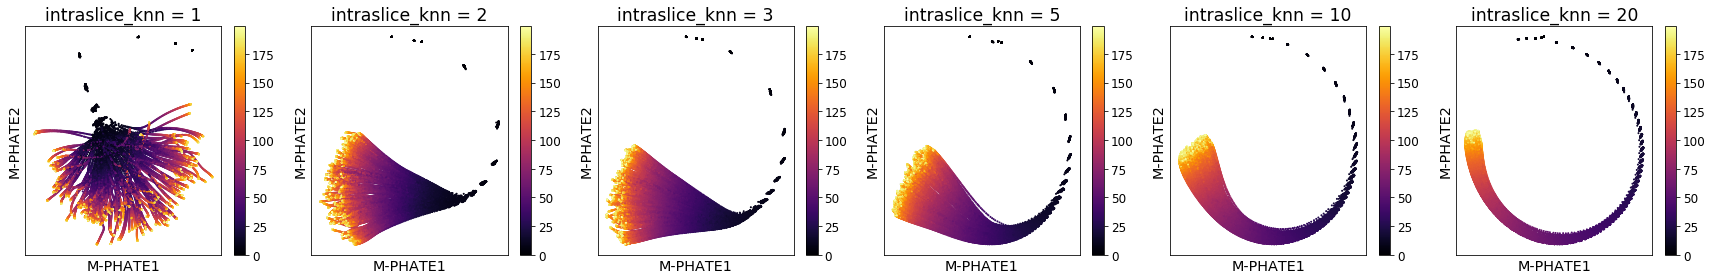

In [4]:
param_name = 'intraslice_knn'
fig, axes = plt.subplots(1, len(results[param_name]), figsize=(4*len(results[param_name]), 4))
for param, ax in zip(results[param_name], axes):
    scprep.plot.scatter2d(results[param_name][param], 
                          c=epoch, ticks=False,
                          ax=ax, label_prefix="M-PHATE",
                          title="{} = {}".format(param_name, param))

plt.tight_layout()

### `interslice_knn` (default: 25)

`intraslice_knn` controls the index of the nearest neighbor the average distance to which defines the kernel bandwidth for each neuron across all epochs. The default is `25`. Increasing `interslice_knn` will increasingly epochs of the same neuron together.

In [5]:
param_name = 'interslice_knn'
params = [5, 10, 15, 20, 25, 30, 40, 50]
results[param_name] = {}

for param in params:
    m_phate_op = m_phate.M_PHATE(verbose=0, **{param_name : param})
    m_phate_data = m_phate_op.fit_transform(trace_data)
    results[param_name][param] = m_phate_data

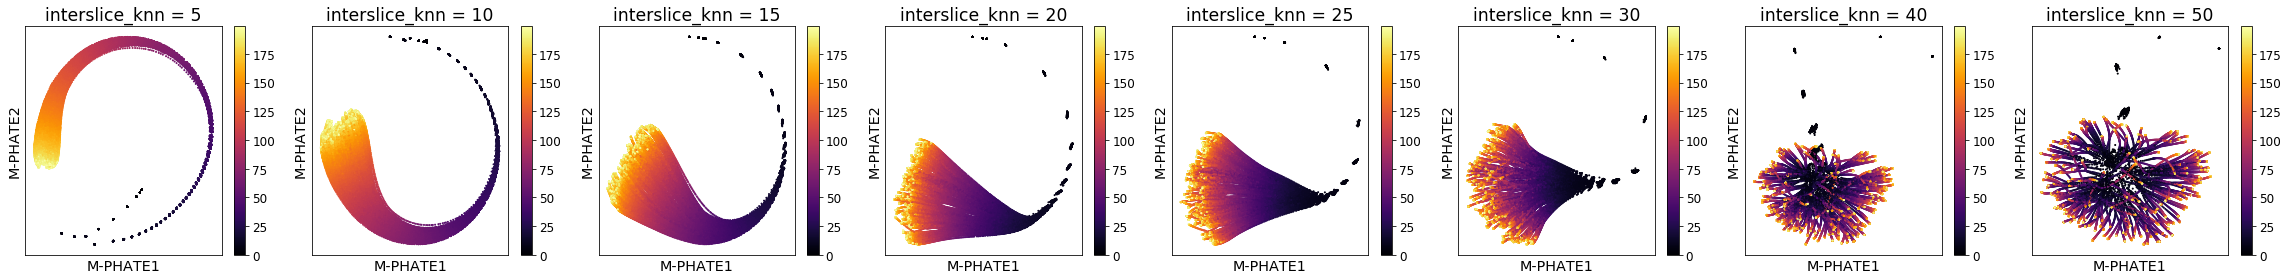

In [6]:
param_name = 'interslice_knn'
fig, axes = plt.subplots(1, len(results[param_name]), figsize=(4*len(results[param_name]), 4))
for param, ax in zip(results[param_name], axes):
    scprep.plot.scatter2d(results[param_name][param], 
                          c=epoch, ticks=False,
                          ax=ax, label_prefix="M-PHATE",
                          title="{} = {}".format(param_name, param))

plt.tight_layout()

### `n_landmark` (default: 4000)

`n_landmark` controls the number of points to which the graph is reduced before embedding by MDS. The default is `4000`. The more landmarks, the slower the embedding will be; however, with too few landmarks, we start to see artifacts of the linear interpolations between them.

In [7]:
param_name = 'n_landmark'
params = [100, 200, 500, 1000, 2000, 4000, 8000]
results[param_name] = {}

m_phate_op = m_phate.M_PHATE(verbose=0)
for param in params:
    m_phate_op.set_params(**{param_name : param})
    # temporary workaround
    m_phate_op._reset_embedding()
    m_phate_op._reset_potential()
    m_phate_data = m_phate_op.fit_transform(trace_data)
    results[param_name][param] = m_phate_data

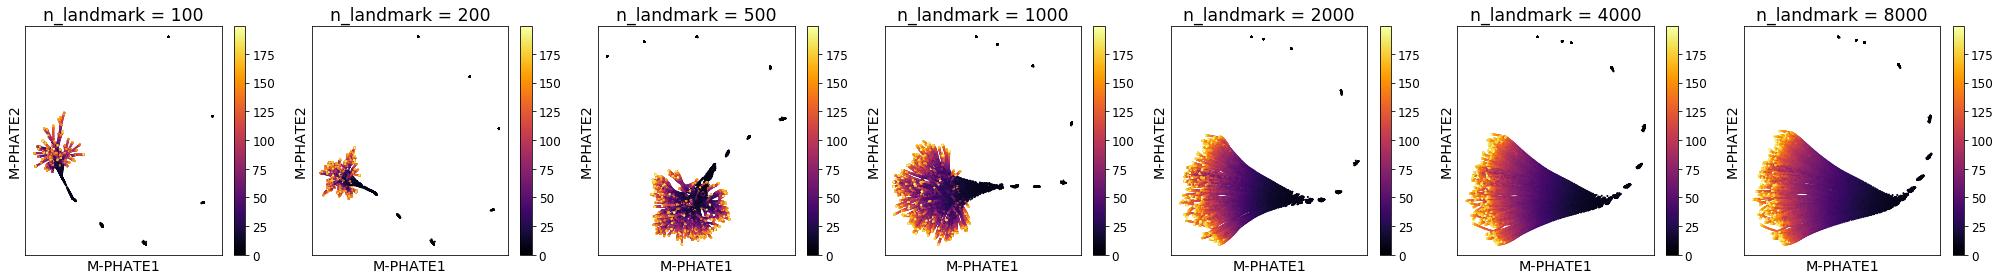

In [8]:
param_name = 'n_landmark'
fig, axes = plt.subplots(1, len(results[param_name]), figsize=(4*len(results[param_name]), 4))
for param, ax in zip(results[param_name], axes):
    scprep.plot.scatter2d(results[param_name][param], 
                          c=epoch, ticks=False,
                          ax=ax, label_prefix="M-PHATE",
                          title="{} = {}".format(param_name, param))

plt.tight_layout()

## Other tunable parameters
### `decay` (default: 5)

`decay` sets the rate of decay of the intraslice kernel tails. The default is `5`. Decreasing `decay` increases the width of the kernel, bringing neurons of the same epoch closer together. `decay=None` gives a binary k-nearest neighbor kernel.

In [9]:
param_name = 'decay'
params = [2, 3, 5, 10, 20, 40, None]
results[param_name] = {}

for param in params:
    m_phate_op = m_phate.M_PHATE(verbose=0, **{param_name : param})
    m_phate_data = m_phate_op.fit_transform(trace_data)
    results[param_name][param] = m_phate_data

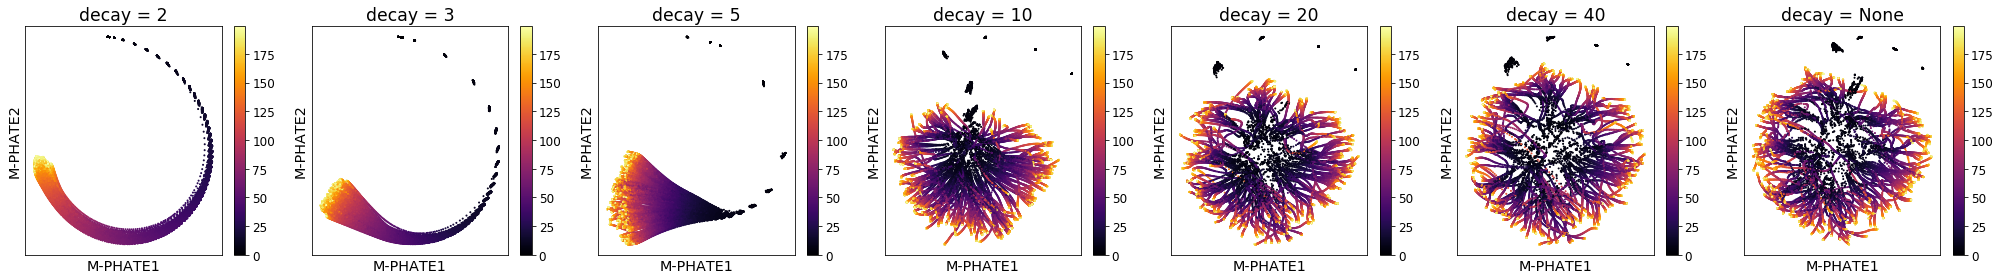

In [10]:
param_name = 'decay'
fig, axes = plt.subplots(1, len(results[param_name]), figsize=(4*len(results[param_name]), 4))
for param, ax in zip(results[param_name], axes):
    scprep.plot.scatter2d(results[param_name][param], 
                          c=epoch, ticks=False,
                          ax=ax, label_prefix="M-PHATE",
                          title="{} = {}".format(param_name, param))

plt.tight_layout()

### `gamma` (default: 0)

`gamma` selects the PHATE information distance. The default is `0`, and it can be set between `-1` and `1`. `1` gives the classic PHATE log potential which emphasizes global structure; `0` gives the PHATE square root potential which emphasizes local structure.

In [11]:
param_name = 'gamma'
params = [-1, 0, 1]
results[param_name] = {}

m_phate_op = m_phate.M_PHATE(verbose=0)
for param in params:
    m_phate_op.set_params(**{param_name : param})
    m_phate_data = m_phate_op.fit_transform(trace_data)
    results[param_name][param] = m_phate_data

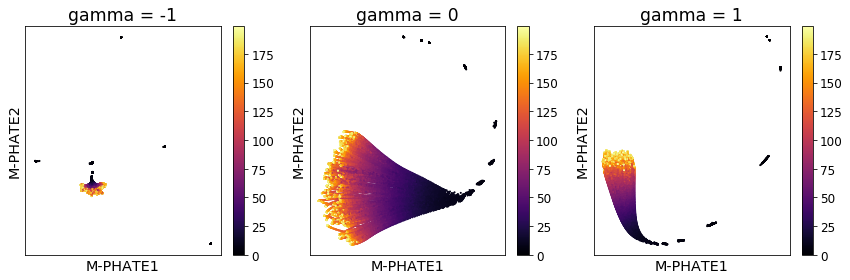

In [12]:
param_name = 'gamma'
fig, axes = plt.subplots(1, len(results[param_name]), figsize=(4*len(results[param_name]), 4))
for param, ax in zip(results[param_name], axes):
    scprep.plot.scatter2d(results[param_name][param], 
                          c=epoch, ticks=False,
                          ax=ax, label_prefix="M-PHATE",
                          title="{} = {}".format(param_name, param))

plt.tight_layout()